<a href="https://colab.research.google.com/github/AritraStark/E2E_GSOC_2022/blob/main/E2E_eval_task_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Common Task 1. Electron/photon classification**

Datasets:

https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)

https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

Description: 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter
Please use a deep learning method of your choice to achieve the highest possible
classification on this dataset (we ask that you do it both in Keras/Tensorflow and in PyTorch). Please provide a Jupyter notebook that shows your solution. The model yousubmit should have a ROC AUC score of at least 0.80.

Downloading the datasets from the links provided: 

In [1]:
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O photons.hdf5
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O electrons.hdf5

--2022-03-31 06:30:23--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703858 (114M) [application/octet-stream]
Saving to: ‘photons.hdf5’

photons.hdf5        100%[===================>] 114.16M  20.6MB/s    in 6.5s    

Last-modified header invalid -- time-stamp ignored.
2022-03-31 06:30:45 (17.6 MB/s) - ‘photons.hdf5’ saved [119703858/119703858]

--2022-03-31 06:30:45--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘electrons.hdf5’

elect

Setting up the imports:

In [1]:
import numpy as np
import tensorflow as tf
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

print(tf.__version__)

2.8.0


Get the data from the downloaded HDF5 files and combine the loaded datasets:

In [2]:
X_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="X")[()])
y_electron = np.array(h5py.File("electrons.hdf5",'r').get(name="y")[()])
X_photon = np.array(h5py.File("photons.hdf5",'r').get(name="X")[()])
y_photon = np.array(h5py.File("photons.hdf5",'r').get(name="y")[()])

X_particles = np.concatenate((X_electron,X_photon),axis=0)
y_particles = np.concatenate((y_electron,y_photon),axis=0)
print(X_particles.shape,y_particles.shape)

del X_electron
del X_photon
del y_electron
del y_photon

(498000, 32, 32, 2) (498000,)


Flattening the data: 

In [ ]:
stream_data = X_particles[:,:,:,0].reshape(-1,32*32)
stream_data.shape

(498000, 1024)

Randomizing data:

In [ ]:
np.random.seed(48)
rng_state = np.random.get_state()
np.random.shuffle(stream_data)
np.random.set_state(rng_state)
np.random.shuffle(y_particles)

Splitting the data into training and testing sets ( I have split it in 80-20 as per instructions): 

In [3]:
X_train, X_test, y_train, y_test = train_test_split( X_particles, y_particles, random_state=48, test_size=0.2 )

#del stream_data
del X_particles
del y_particles

Defining the model:

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, 7, activation = 'relu', padding='same', input_shape =X_train.shape[1:]),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv2D(64, 7, activation = 'relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation = 'relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

Defining callbacks:

In [10]:
filepath="classifier_weights2-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint1 = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

Compiling the model and fitting it with testing data:

In [1]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,  y_train, 
                    validation_split=0.2, 
                    epochs=200, 
                    batch_size=128,
                    callbacks=callbacks_list)

NameError: ignored

Plotting the results:

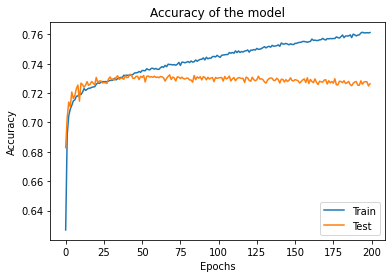

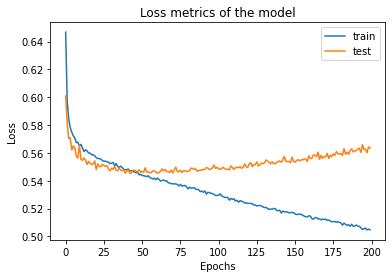

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss metrics of the model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Check the performance of the model on predictions:

In [ ]:
best_epoch=np.argmax(history.history['val_accuracy'])
best_acc=np.max(history.history['val_accuracy'])
model.load_weights(f"classifier_weights2-improvement-{best_epoch+1}-{best_acc:.2f}.hdf5")
predictions = model.predict(X_train)
bin =[0 if p<0.5 else 1 for p in predictions]

Classification Report and ROC AUC score:

In [ ]:
print(classification_report(y_train,bin))
print("ROC AUC:")
roc_auc_score(y_train, bin)

              precision    recall  f1-score   support

         0.0       0.75      0.72      0.74    199124
         1.0       0.73      0.77      0.75    199276

    accuracy                           0.74    398400
   macro avg       0.74      0.74      0.74    398400
weighted avg       0.74      0.74      0.74    398400



0.7428705025125608

Classification Report and ROC AUC score on test data:

In [ ]:
del predictions
del bin
predictions = model.predict(X_test)
bin =[0 if p<0.5 else 1 for p in predictions]
print(classification_report(y_test,bin))
print("ROC AUC:")
roc_auc_score(y_test, bin)

**References :**


1.   [Examining Electron and Photon Classification Using Convolutional Neural Networks
Jonah Warner, Research Assistant
Department of Physics, Carnegie Mellon University, Pittsburgh 15213](https://www.cmu.edu/ai-physics-institute/outreach/surp/images/2021/jonah-warner-poster.pdf)
2.   [End-to-End Event Classification of High-Energy
Physics Data
M Andrews
, M Paulini
, S Gleyzer
, B Poczos](https://indico.cern.ch/event/567550/papers/2629451/files/7515-end-end-event_v4.pdf)
3.   [Calorimetry with Deep Learning: Particle
Classification, Energy Regression, and Simulation for
High-Energy Physics
Federico Carminati, Gulrukh Khattak, Maurizio Pierini
CERN](https://dl4physicalsciences.github.io/files/nips_dlps_2017_15.pdf)
4.  [Electron/Photon Ambiguity Resolution Using Neural
networks For ATLAS Experiment
Nutthawara Buatthaisong, Khon Kaen University, Thailand
](https://www.desy.de/f/students/2019/reports/nutthawara.buatthaisong.pdf)
